In [3]:
import json
import os
import matplotlib.pyplot as plt

In [5]:
train_dir = "/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/train"
valid_dir = "/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/valid"
test_dir = "/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/test"

In [7]:
def extract_classes(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    categories = data.get('categories', [])
    class_names = [category['name'] for category in categories]
    return class_names

train_classes = extract_classes(os.path.join(train_dir, "_annotations.coco.json"))
valid_classes = extract_classes(os.path.join(valid_dir, "_annotations.coco.json"))
test_classes = extract_classes(os.path.join(test_dir, "_annotations.coco.json"))

all_classes = set(train_classes + valid_classes + test_classes)
print("Unique object classes:", all_classes)

Unique object classes: {'ship', 'vehicle', 'Aircraft'}


In [9]:
def count_images(directory):
    return len([file for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))])

train_image_count = count_images(train_dir)
valid_image_count = count_images(valid_dir)
test_image_count = count_images(test_dir)

print("Number of train images:", train_image_count)
print("Number of validation images:", valid_image_count)
print("Number of test images:", test_image_count)

Number of train images: 2094
Number of validation images: 449
Number of test images: 449


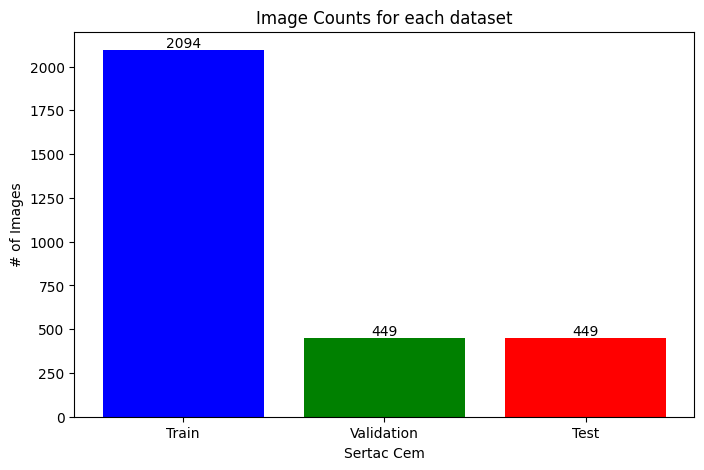

In [ ]:
plt.figure(figsize=(8, 5))
counts = [train_image_count, valid_image_count, test_image_count]
labels = ['Train', 'Validation', 'Test']
bars = plt.bar(labels, counts, color=['blue', 'green', 'red'])
plt.title('Image Counts for each dataset')
plt.xlabel('Sertac Cem') #Signature of mine :)
plt.ylabel('# of Images')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom')

plt.show()

In [27]:
def class_distribution(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    categories = data.get('categories', [])
    category_map = {category['id']: category['name'] for category in categories}
    
    annotations = data.get('annotations', [])
    class_counts = {}
    for annotation in annotations:
        category_id = annotation['category_id']
        category_name = category_map.get(category_id, 'Unknown')
        class_counts[category_name] = class_counts.get(category_name, 0) + 1
    
    return class_counts

train_class_dist = class_distribution(os.path.join(train_dir, "_annotations.coco.json"))
valid_class_dist = class_distribution(os.path.join(valid_dir, "_annotations.coco.json"))
test_class_dist = class_distribution(os.path.join(test_dir, "_annotations.coco.json"))

def merge_class_distributions(*distributions):
    merged = {}
    for dist in distributions:
        for key, value in dist.items():
            merged[key] = merged.get(key, 0) + value
    return merged

combined_class_dist = merge_class_distributions(train_class_dist, valid_class_dist, test_class_dist)

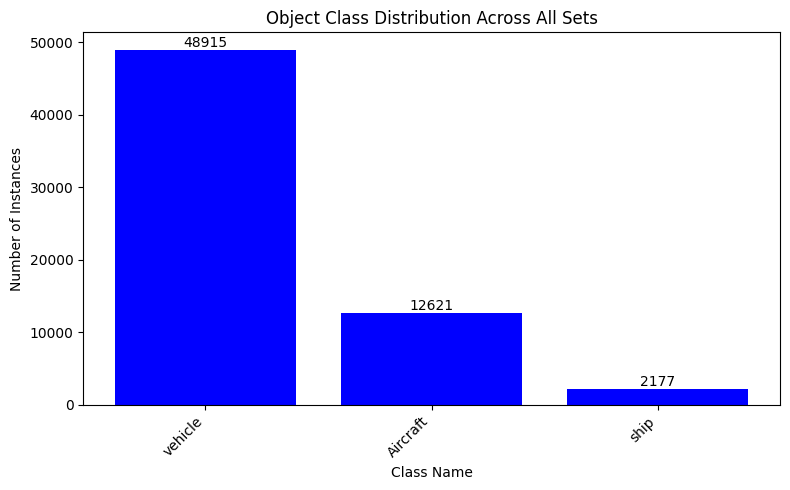

In [ ]:
plt.figure(figsize=(8, 5))
bars = plt.bar(combined_class_dist.keys(), combined_class_dist.values(), color='blue')
plt.title('Object Class Distribution Across All Sets')
plt.xlabel('Class Name')
plt.ylabel('Number of Instances')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 
plt.show()

In [31]:
def convert_coco_to_yolo(coco_file, output_dir):
    with open(coco_file, 'r') as f:
        data = json.load(f)
    
    categories = data['categories']
    category_map = {category['id']: idx for idx, category in enumerate(categories)}

    for image_info in data['images']:
        image_id = image_info['id']
        image_width = image_info['width']
        image_height = image_info['height']
        file_name = os.path.splitext(image_info['file_name'])[0]

        yolo_file_path = os.path.join(output_dir, f"{file_name}.txt")
        with open(yolo_file_path, 'w') as yolo_file:
            for annotation in data['annotations']:
                if annotation['image_id'] == image_id:
                    category_id = annotation['category_id']
                    yolo_class_id = category_map[category_id]

                    bbox = annotation['bbox']
                    x, y, width, height = bbox

                    x_center = (x + width / 2) / image_width
                    y_center = (y + height / 2) / image_height
                    width /= image_width
                    height /= image_height

                    yolo_file.write(f"{yolo_class_id} {x_center} {y_center} {width} {height}\n")

    print(f"Conversion completed for {coco_file}. Annotations saved to {output_dir}")

In [33]:
train_coco_file = os.path.join(train_dir, '_annotations.coco.json')
valid_coco_file = os.path.join(valid_dir, '_annotations.coco.json')
test_coco_file = os.path.join(test_dir, '_annotations.coco.json')

convert_coco_to_yolo(train_coco_file, train_dir)
convert_coco_to_yolo(valid_coco_file, valid_dir)
convert_coco_to_yolo(test_coco_file, test_dir)

Conversion completed for /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/train/_annotations.coco.json. Annotations saved to /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/train
Conversion completed for /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/valid/_annotations.coco.json. Annotations saved to /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/valid
Conversion completed for /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/test/_annotations.coco.json. Annotations saved to /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/test


In [ ]:
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm
import shutil


transform = A.Compose([
    A.Resize(512, 512),  
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.2), 
    # This part is a little bit interesting, let's try it is working or not
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [37]:
def preprocess_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for img_name in tqdm(os.listdir(input_dir)):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            
            img_path = os.path.join(input_dir, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            
            transformed = transform(image=image)
            transformed_image = transformed['image']
            
            output_path = os.path.join(output_dir, img_name)
            cv2.imwrite(output_path, transformed_image * 255)
            
            txt_name = os.path.splitext(img_name)[0] + '.txt'
            txt_path = os.path.join(input_dir, txt_name)
            if os.path.exists(txt_path):
                shutil.move(txt_path, os.path.join(output_dir, txt_name))

In [39]:
train_preprocessed_dir = os.path.join(train_dir, "preprocessed")
valid_preprocessed_dir = os.path.join(valid_dir, "preprocessed")
test_preprocessed_dir = os.path.join(test_dir, "preprocessed")

preprocess_images(train_dir, train_preprocessed_dir)
preprocess_images(valid_dir, valid_preprocessed_dir)
preprocess_images(test_dir, test_preprocessed_dir)

100%|██████████| 902/902 [00:01<00:00, 471.80it/s]


In [ ]:
from ultralytics import YOLO

data_yaml = "/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/satellite_data.yaml"

model = YOLO('yolov8s.pt')

# Let's trian our model!!!
model.train(data=data_yaml, epochs=10, batch=16, imgsz=416, name='satellite_yolo_model')

New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.9 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/satellite_data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=satellite_yolo_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cla

train: Scanning /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/train/preprocessed... 2094 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2094/2094 [00:00<00:00, 4084.01it/s]

train: New cache created: /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/train/preprocessed.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/valid/preprocessed... 449 images, 0 backgrounds, 0 corrupt: 100%|██████████| 449/449 [00:00<00:00, 4579.61it/s]

val: New cache created: /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/valid/preprocessed.cache


Plotting labels to runs/detect/satellite_yolo_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/satellite_yolo_model
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.787      3.554      1.503        667        512: 100%|██████████| 131/131 [19:41<00:00,  9.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:56<00:00,  7.77s/it]

                   all        449       8387      0.151     0.0327     0.0589     0.0273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.675      2.763      1.353        363        512: 100%|██████████| 131/131 [20:52<00:00,  9.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:05<00:00,  8.39s/it]

                   all        449       8387     0.0799       0.15     0.0197    0.00886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       2.58      2.496      1.286        237        512: 100%|██████████| 131/131 [19:56<00:00,  9.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:56<00:00,  7.75s/it]

                   all        449       8387      0.152      0.124     0.0615     0.0291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.616       2.52      1.299         68        512: 100%|██████████| 131/131 [20:20<00:00,  9.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:01<00:00,  8.08s/it]

                   all        449       8387      0.178      0.121     0.0713     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      2.572      2.423      1.287        816        512: 100%|██████████| 131/131 [20:09<00:00,  9.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:02<00:00,  8.14s/it]

                   all        449       8387      0.449      0.138     0.0916     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.443      2.293      1.252        348        512: 100%|██████████| 131/131 [21:59<00:00, 10.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:04<00:00,  8.28s/it]


                   all        449       8387      0.292      0.153        0.1     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      2.402      2.198      1.239        260        512: 100%|██████████| 131/131 [21:17<00:00,  9.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:00<00:00,  8.00s/it]

                   all        449       8387      0.266      0.158      0.101      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      2.373      2.182      1.215        172        512: 100%|██████████| 131/131 [22:25<00:00, 10.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:10<00:00,  8.69s/it]

                   all        449       8387      0.275      0.169      0.105     0.0555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      2.324      2.137      1.201        140        512: 100%|██████████| 131/131 [22:29<00:00, 10.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:06<00:00,  8.42s/it]

                   all        449       8387       0.32      0.173       0.11     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      2.313      2.116      1.188        211        512: 100%|██████████| 131/131 [21:47<00:00,  9.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:54<00:00,  7.65s/it]

                   all        449       8387      0.301      0.177      0.107     0.0567



10 epochs completed in 3.857 hours.
Optimizer stripped from runs/detect/satellite_yolo_model/weights/last.pt, 19.9MB
Optimizer stripped from runs/detect/satellite_yolo_model/weights/best.pt, 19.9MB

Validating runs/detect/satellite_yolo_model/weights/best.pt...
Ultralytics 8.3.9 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M2)
Model summary (fused): 186 layers, 9,828,825 parameters, 0 gradients, 23.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:45<00:00,  7.04s/it]


                   all        449       8387      0.316      0.173       0.11     0.0586
              Aircraft        149       1957      0.419      0.442      0.258      0.154
                  ship        150        288      0.377     0.0278     0.0479     0.0156
               vehicle        150       6142      0.152     0.0485     0.0248    0.00645
Speed: 0.7ms preprocess, 221.3ms inference, 0.0ms loss, 9.9ms postprocess per image
Results saved to runs/detect/satellite_yolo_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x35b5b8970>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [44]:
metrics = model.val()

Ultralytics 8.3.9 🚀 Python-3.9.20 torch-2.4.1 CPU (Apple M2)
Model summary (fused): 186 layers, 9,828,825 parameters, 0 gradients, 23.3 GFLOPs


val: Scanning /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/valid/preprocessed.cache... 449 images, 0 backgrounds, 0 corrupt: 100%|██████████| 449/449 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [01:52<00:00,  3.88s/it]


                   all        449       8387      0.316      0.173       0.11     0.0586
              Aircraft        149       1957      0.419      0.442      0.258      0.154
                  ship        150        288      0.377     0.0278     0.0479     0.0156
               vehicle        150       6142      0.152     0.0485     0.0248    0.00645
Speed: 0.5ms preprocess, 239.8ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to runs/detect/satellite_yolo_model2


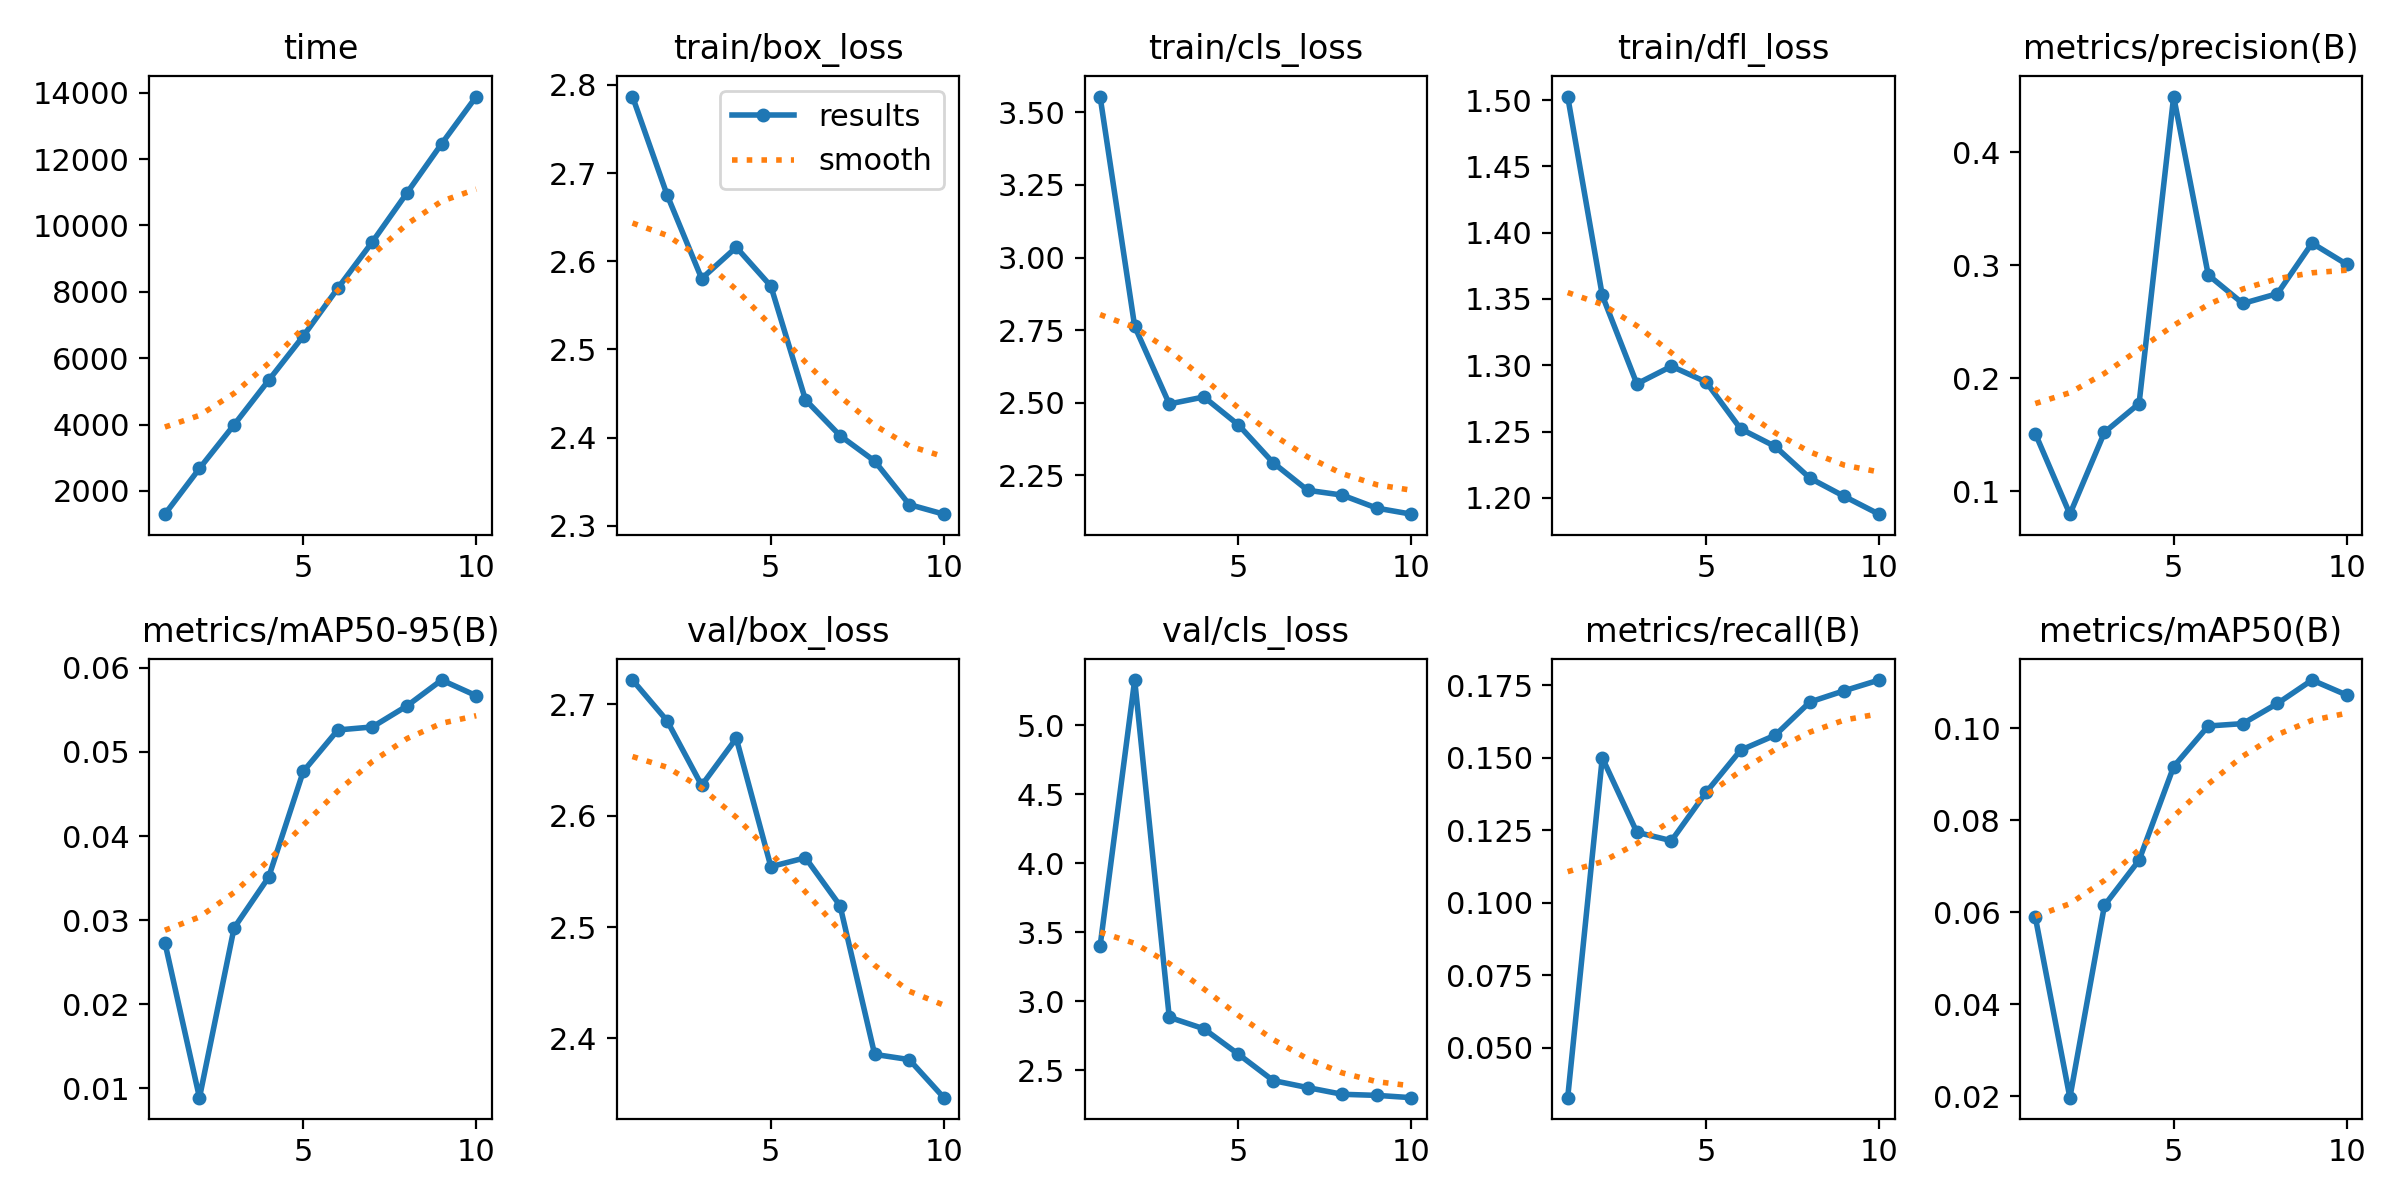

In [50]:
from IPython.display import Image
Image(filename='/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/runs/detect/satellite_yolo_model/results.png')

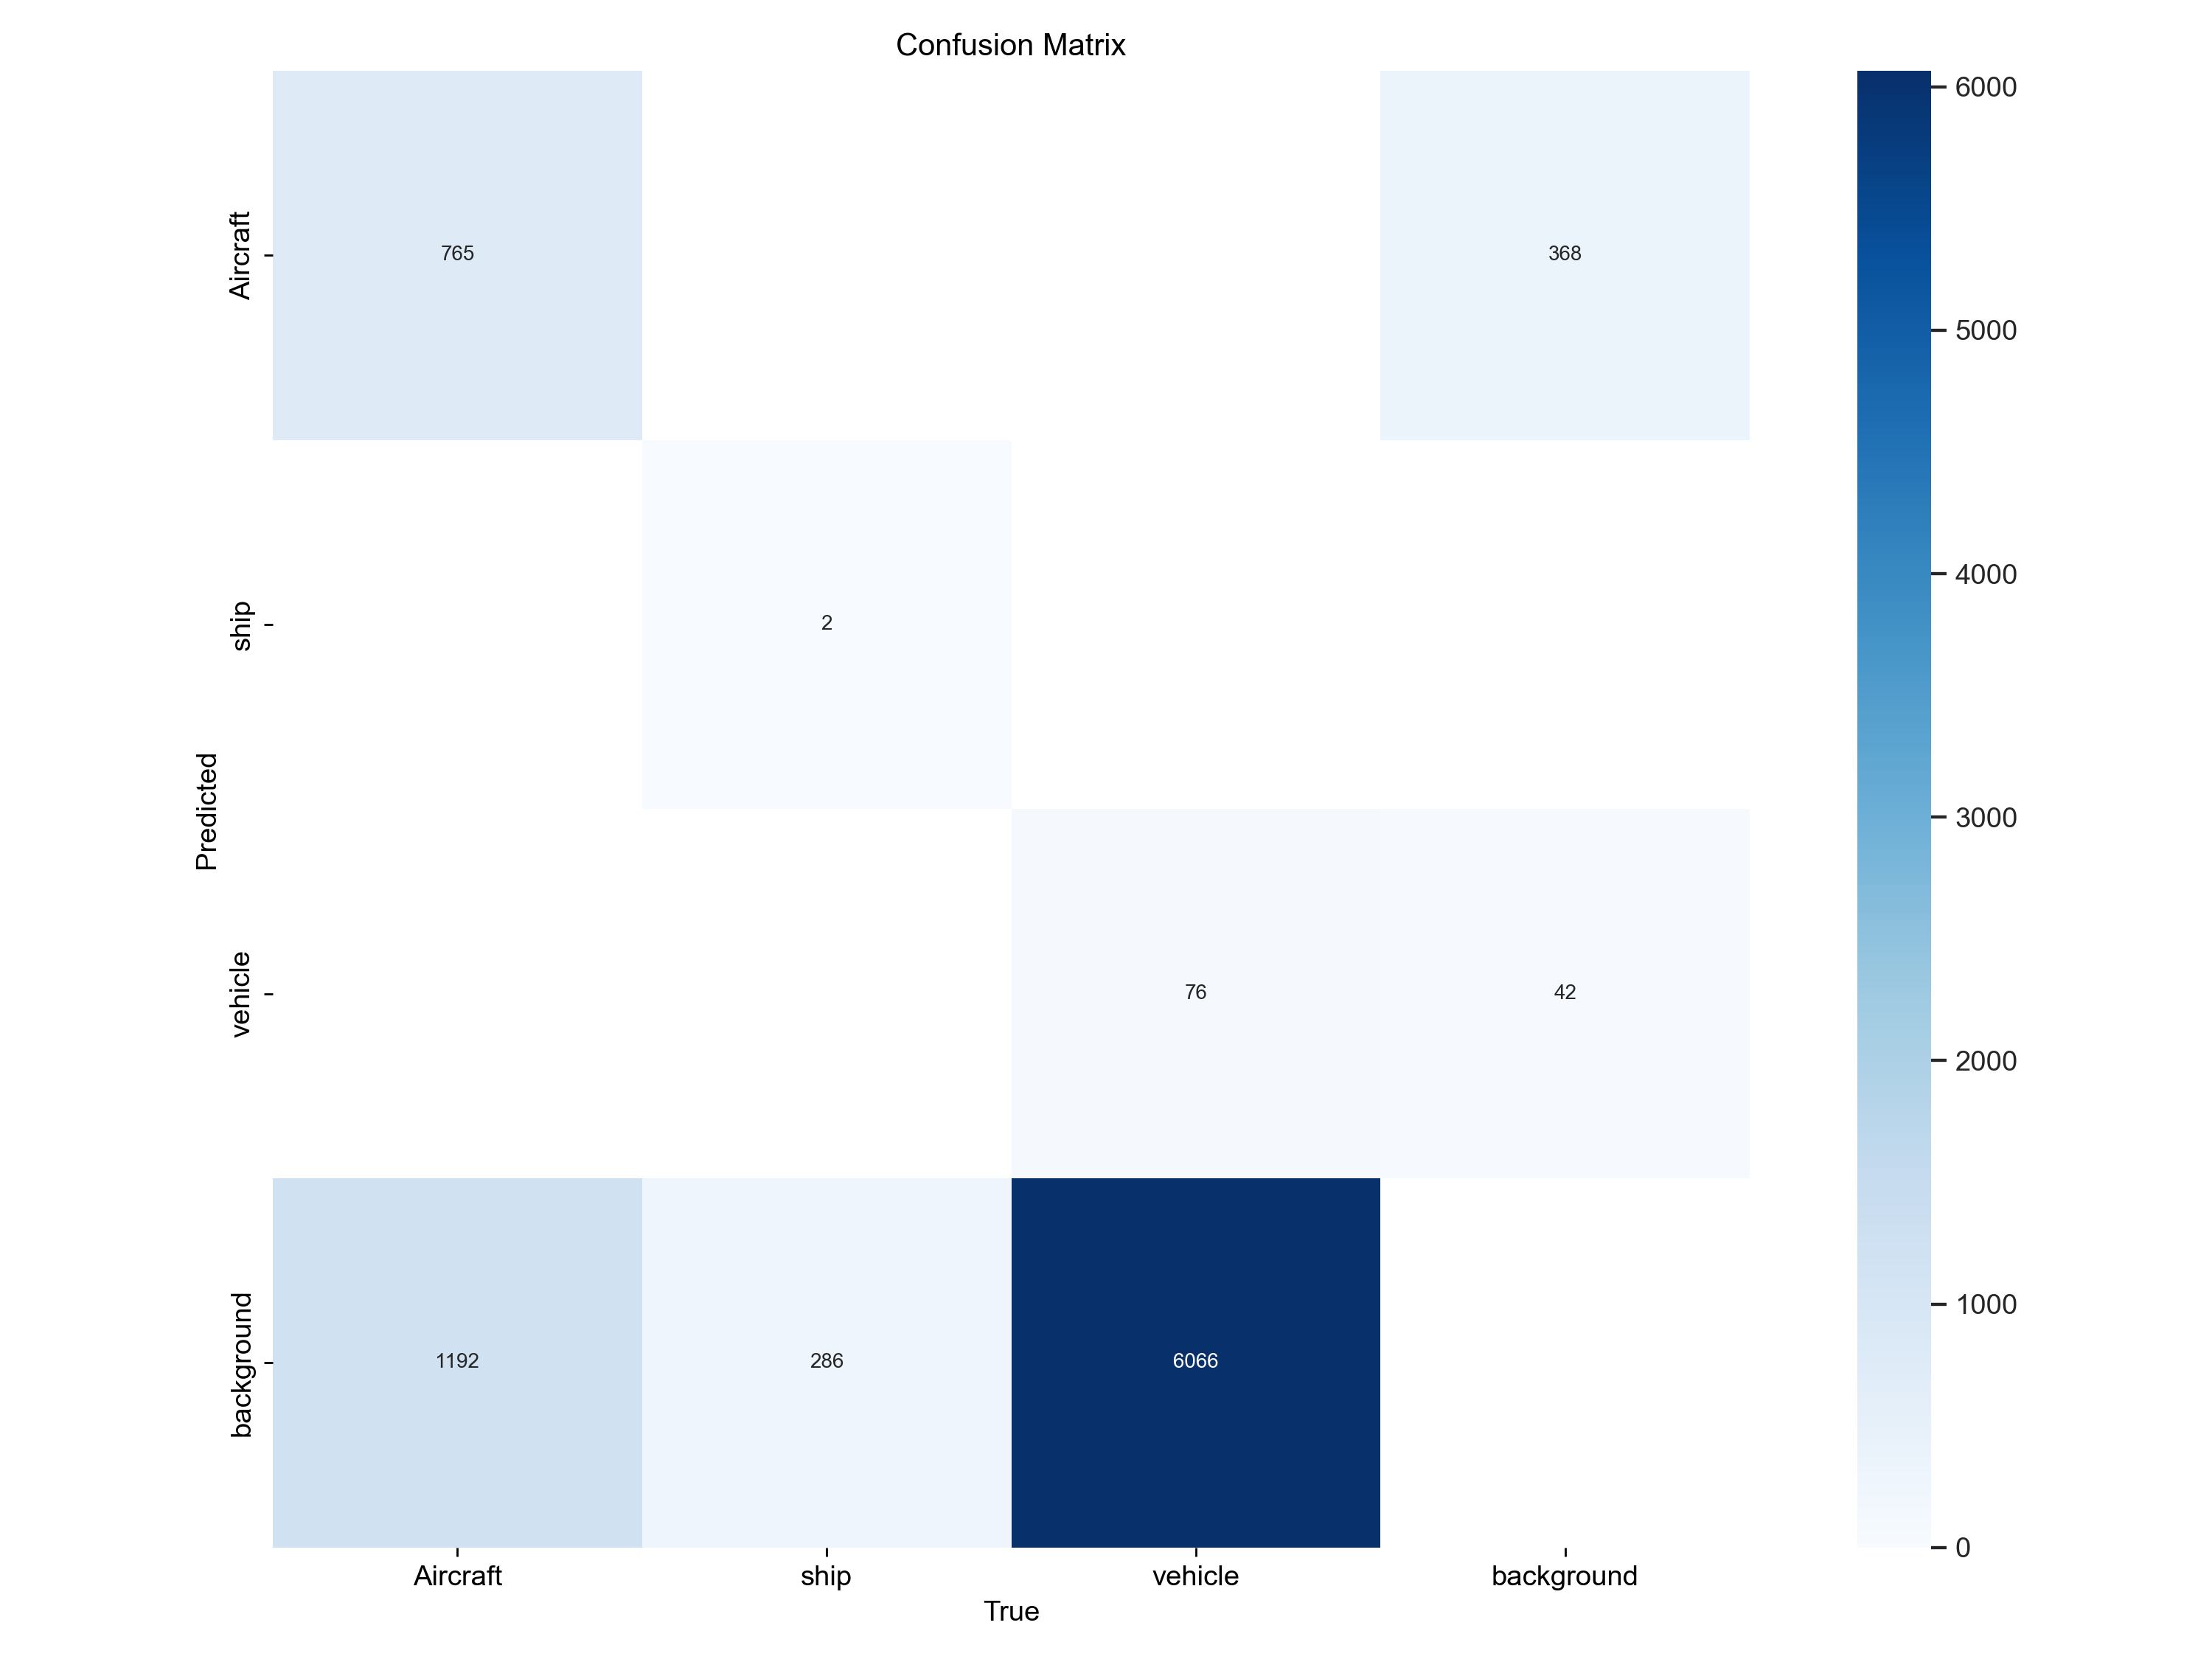

In [54]:
Image(filename='/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/runs/detect/satellite_yolo_model2/confusion_matrix.png')

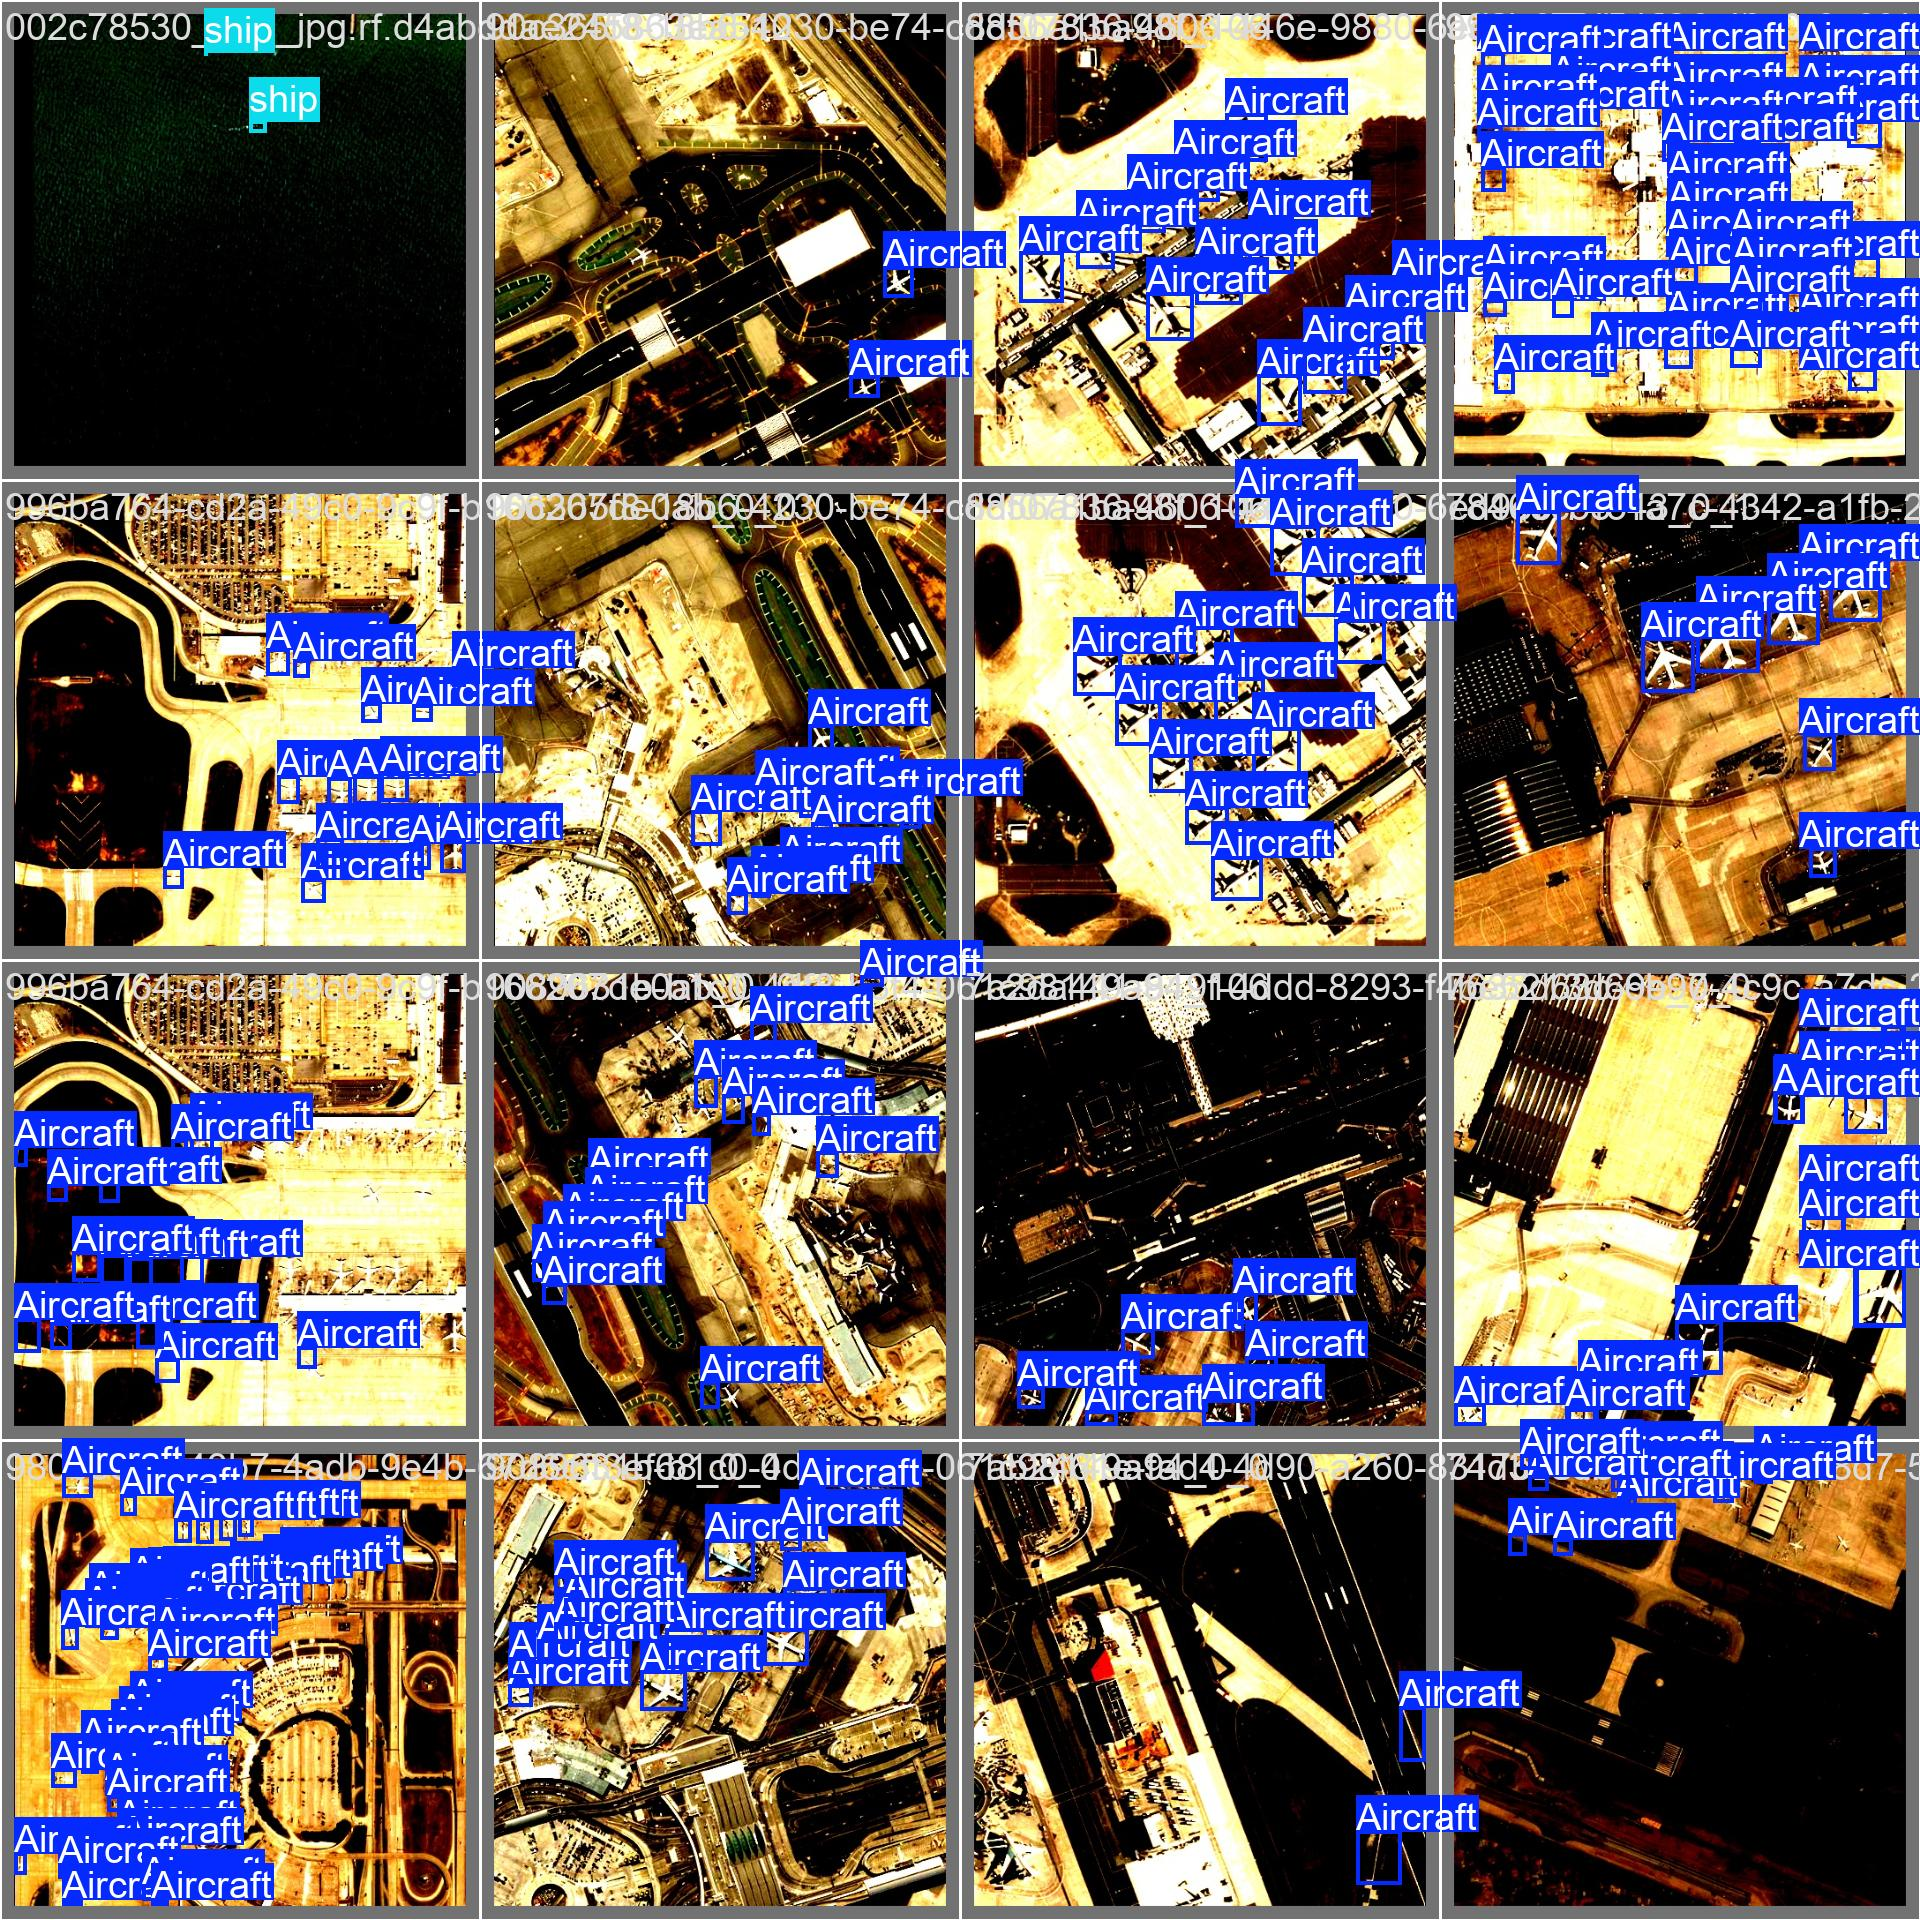

In [56]:
Image(filename='/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/runs/detect/satellite_yolo_model2/val_batch0_labels.jpg')

In [66]:
from ultralytics import YOLO
import torch
print(torch.backends.mps.is_available())

True


In [ ]:
from ultralytics import YOLO

data_yaml = "/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/satellite_data.yaml"
# Started with small model, other ones took too much time!!!
model = YOLO('yolov8s.pt')

# MPS(GPU for Apple macbook) will be activated
model.train(data=data_yaml, epochs=30, batch=16, imgsz=512, name='satellite_yolo_model', device = 'mps' )

New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.9 🚀 Python-3.9.20 torch-2.4.1 MPS (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/satellite_data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=satellite_yolo_model4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cla

train: Scanning /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/train/preprocessed.cache... 2094 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2094/2094 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/sertaccem/PycharmProjects/BSBI/CV and AI/Second Assignment/Own_Dataset_2/valid/preprocessed.cache... 449 images, 0 backgrounds, 0 corrupt: 100%|██████████| 449/449 [00:00<?, ?it/s]

Plotting labels to runs/detect/satellite_yolo_model4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/satellite_yolo_model4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      16.5G      2.695      3.245      1.447        282        512: 100%|██████████| 131/131 [15:56<00:00,  7.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:18<04:20, 18.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [00:33<03:32, 16.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [00:43<02:41, 13.42s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [00:53<02:11, 12.00s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [01:03<01:54, 11.49s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [01:17<01:51, 12.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [01:31<01:41, 12.75s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [01:39<01:19, 11.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [01:48<01:02, 10.43s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [01:56<00:48,  9.69s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [02:03<00:35,  8.95s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [02:11<00:26,  8.69s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [02:19<00:16,  8.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:38<00:00, 10.57s/it]


                   all        449       8387    0.00674     0.0607     0.0117    0.00483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      16.7G      2.573      2.515      1.309        315        512: 100%|██████████| 131/131 [12:09<00:00,  5.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:08<02:00,  8.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [00:17<01:56,  8.97s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [00:24<01:34,  7.84s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [00:32<01:25,  7.79s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [00:39<01:17,  7.79s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [00:49<01:16,  8.47s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [00:57<01:07,  8.45s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [01:04<00:54,  7.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [01:11<00:46,  7.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [01:19<00:39,  7.82s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [01:29<00:33,  8.35s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [01:36<00:23,  7.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [01:45<00:16,  8.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:56<00:00,  7.74s/it]

                   all        449       8387     0.0924     0.0217      0.018    0.00817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30        17G      2.577       2.42      1.298        189        512: 100%|██████████| 131/131 [12:39<00:00,  5.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:09<02:10,  9.30s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [00:18<02:00,  9.26s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [00:25<01:37,  8.13s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [00:33<01:29,  8.16s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [00:41<01:22,  8.21s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [00:52<01:20,  8.97s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [01:01<01:12,  9.08s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [01:08<00:58,  8.35s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [01:19<00:54,  9.08s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [01:28<00:46,  9.25s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [01:39<00:38,  9.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [01:46<00:26,  8.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [01:54<00:17,  8.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:05<00:00,  8.34s/it]


                   all        449       8387      0.622     0.0236     0.0185    0.00733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      17.2G      2.527      2.359      1.273        350        512: 100%|██████████| 131/131 [12:30<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:10<02:27, 10.55s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [00:20<02:08,  9.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [00:28<01:49,  9.14s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [00:36<01:36,  8.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [00:45<01:29,  8.94s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [00:54<01:20,  8.96s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [01:04<01:13,  9.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [01:13<01:03,  9.13s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [01:24<00:58,  9.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [01:31<00:45,  9.01s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [01:43<00:38,  9.70s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [01:48<00:25,  8.51s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [01:59<00:18,  9.21s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:07<00:00,  8.47s/it]


                   all        449       8387      0.229     0.0237     0.0206    0.00831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      17.5G      2.549      2.295      1.252        217        512: 100%|██████████| 131/131 [12:40<00:00,  5.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:07<01:46,  7.60s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [00:15<01:37,  7.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [00:21<01:26,  7.23s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [00:29<01:21,  7.44s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [00:38<01:18,  7.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [00:48<01:19,  8.79s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [00:55<01:05,  8.15s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [01:02<00:54,  7.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [01:12<00:51,  8.51s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [01:19<00:40,  8.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [01:29<00:34,  8.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [01:36<00:24,  8.16s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [01:43<00:15,  7.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:51<00:00,  7.45s/it]


                   all        449       8387      0.169     0.0198     0.0161    0.00791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      17.8G      2.534      2.245      1.253        222        512: 100%|██████████| 131/131 [12:34<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:09<02:11,  9.39s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [00:17<01:53,  8.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [00:23<01:27,  7.29s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [00:32<01:29,  8.10s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [00:41<01:24,  8.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [00:53<01:26,  9.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [01:04<01:21, 10.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [01:14<01:10, 10.04s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [01:24<01:00, 10.07s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [01:34<00:49,  9.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [01:45<00:40, 10.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [01:52<00:27,  9.26s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [02:00<00:17,  8.88s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [02:10<00:00,  8.71s/it]


                   all        449       8387      0.265       0.02     0.0181    0.00896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      18.2G      2.461      2.252       1.25        275        512:  44%|████▍     | 58/131 [04:51<06:06,  5.03s/it]


KeyboardInterrupt: 